<a href="https://colab.research.google.com/github/shivadhar13/Credit-Card-Fraud-Detection/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[load_data] Loaded dataset with shape: (284807, 31)
[preprocess] Completed standard scaling for 'Amount' and 'Time'.
[split] Train shape: (199364, 30)  Test shape: (85443, 30)
[split] Train class distribution:
 Class
0    199020
1       344
Name: count, dtype: int64
[fast_smote] Downsampled majority from 199020 to 20000 for prototyping.
[fast_smote] After SMOTE: class counts = [20000 20000]
[pca] Applied PCA: components=10, explained_variance_ratio_sum=0.962
[train_supervised] Training Random Forest, Logistic Regression, Gradient Boosting...
[train_supervised] Supervised models trained.
[autoencoder] Training AE on majority-class PCA data...
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.8541
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6069
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9019
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1031
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0458
Epoch 6/30
40/40 ━━━━━━━

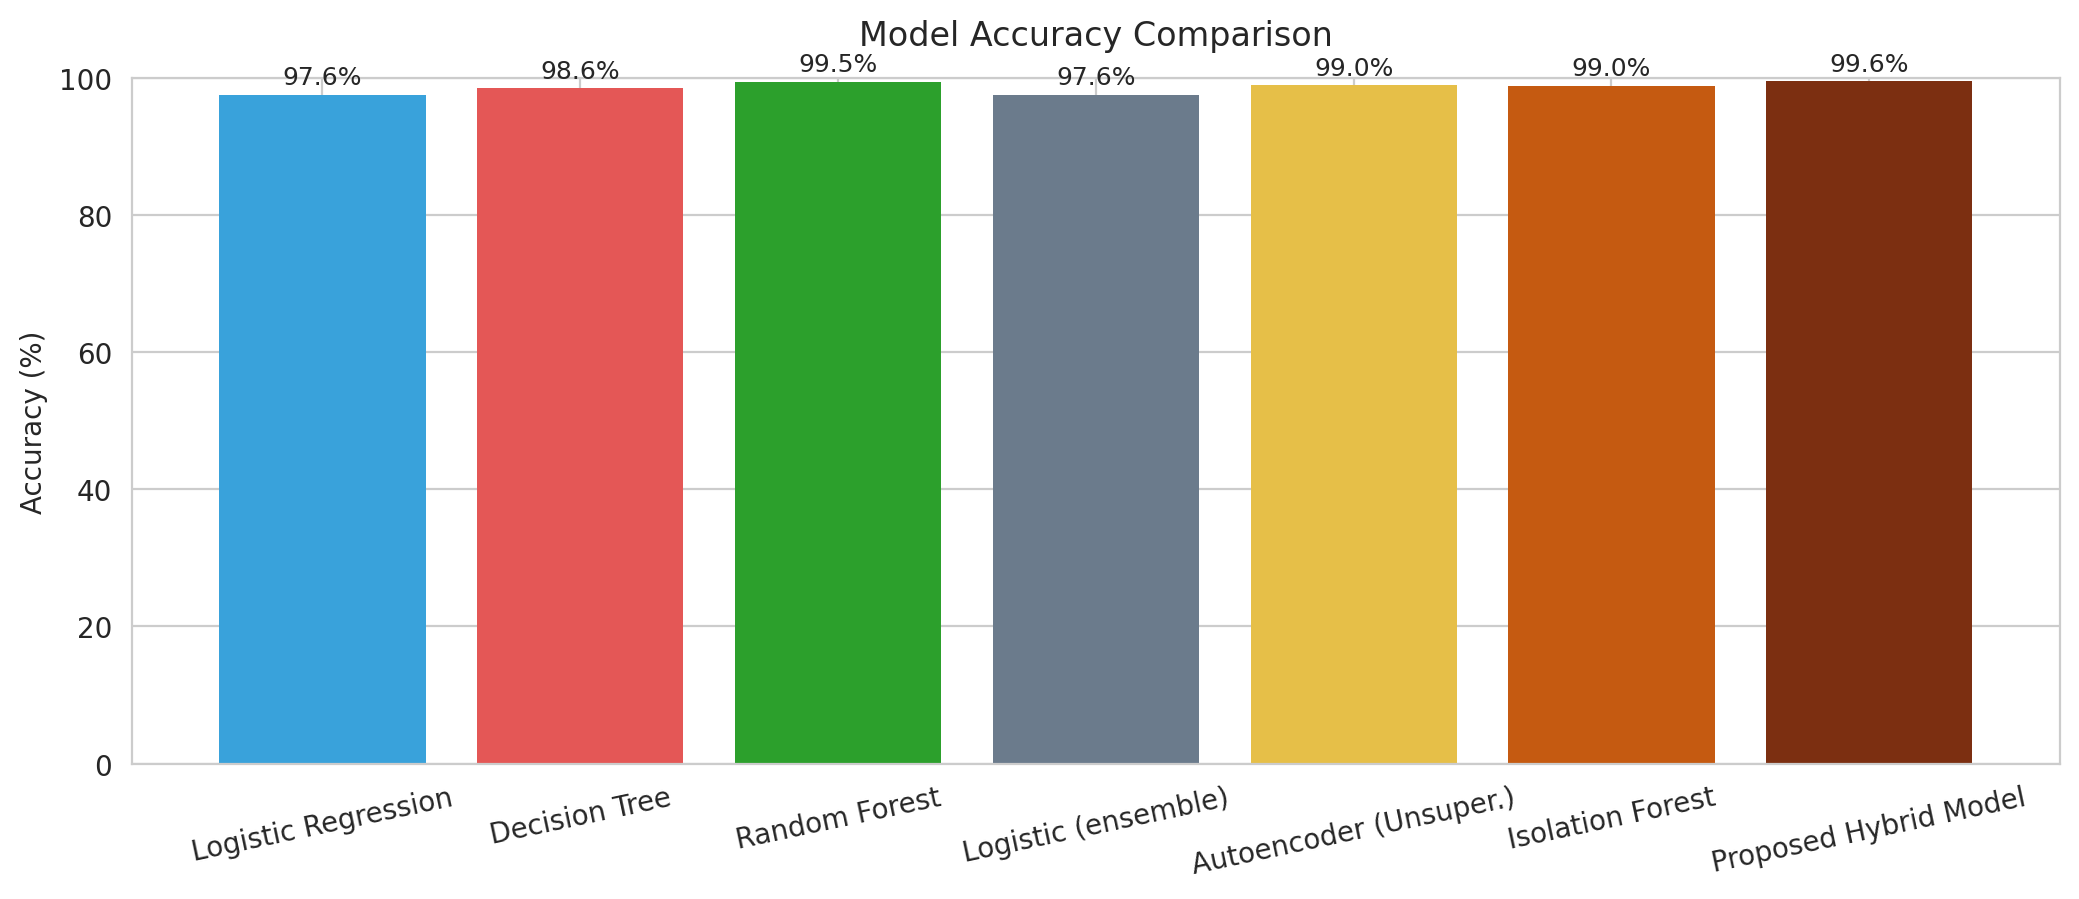

[plot] Saved accuracy chart to: model_accuracy_comparison_fast.png
[done] Pipeline finished successfully.


In [3]:

import os
import random
from typing import Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, optimizers, callbacks

# ---------------------------
# Config / Hyperparameters
# ---------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

DATA_PATH = "creditcard.csv"
MAJORITY_DOWN_TO = 20000      # prototype speed-up: downsample majority to this many rows (set None to keep all)
SMOTE_RANDOM_STATE = SEED

PCA_COMPONENTS = 10           # smaller for fast prototype; increase to 20 for final run
RF_ESTIMATORS = 100
GB_ESTIMATORS = 100
ISO_ESTIMATORS = 100

AE_EPOCHS = 30                # fewer epochs for prototype
AE_BATCH = 512

STACKING_FOLDS = 3            # number of folds for OOF stacking (3 is faster; 5 gives better meta-features)
HOLDOUT_RATIO = 0.20          # for threshold calibration

OUTPUT_CSV = "model_comparative_results_fast.csv"
OUTPUT_PLOT = "model_accuracy_comparison_fast.png"


# ---------------------------
# Utility & pipeline functions
# ---------------------------
def load_data(path: str) -> pd.DataFrame:
    """Load dataset and assert basic expectations."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}. Place 'creditcard.csv' in script folder.")
    df = pd.read_csv(path)
    print(f"[load_data] Loaded dataset with shape: {df.shape}")
    return df


def preprocess(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """Drop NA, scale Time and Amount, return X (features) and y (target)."""
    df = df.dropna()
    X = df.drop(columns=['Class'])
    y = df['Class'].astype(int)
    scaler = StandardScaler()
    # Scale Amount and Time columns (other 28 PCA features are already numeric)
    X_scaled = X.copy()
    X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])
    X_scaled['Time'] = scaler.fit_transform(X[['Time']])
    print("[preprocess] Completed standard scaling for 'Amount' and 'Time'.")
    return X_scaled, y


def train_test_split_stratified(X: pd.DataFrame, y: pd.Series, test_size: float = 0.3, seed: int = SEED):
    """Stratified train-test split and print class distribution."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
    print(f"[split] Train shape: {X_train.shape}  Test shape: {X_test.shape}")
    print("[split] Train class distribution:\n", y_train.value_counts())
    return X_train, X_test, y_train, y_test


def fast_smote_subset(X_train: pd.DataFrame, y_train: pd.Series, maj_down_to: int = MAJORITY_DOWN_TO,
                      random_state: int = SMOTE_RANDOM_STATE) -> Tuple[np.ndarray, np.ndarray]:

    if maj_down_to is not None:
        majority_count = (y_train == 0).sum()
        if majority_count > maj_down_to:
            maj_idx = y_train[y_train == 0].sample(n=maj_down_to, random_state=random_state).index
            min_idx = y_train[y_train == 1].index
            subset_idx = maj_idx.union(min_idx)
            X_train_small = X_train.loc[subset_idx].copy()
            y_train_small = y_train.loc[subset_idx].copy()
            print(f"[fast_smote] Downsampled majority from {majority_count} to {maj_down_to} for prototyping.")
        else:
            X_train_small = X_train.copy()
            y_train_small = y_train.copy()
    else:
        X_train_small = X_train.copy()
        y_train_small = y_train.copy()

    sm = SMOTE(random_state=random_state)
    X_res, y_res = sm.fit_resample(X_train_small, y_train_small)
    print(f"[fast_smote] After SMOTE: class counts = {np.bincount(y_res)}")
    return X_res, y_res, X_train_small, y_train_small


def apply_pca(X_train_resampled: np.ndarray, X_test: np.ndarray, n_components: int = PCA_COMPONENTS):
    """Fit PCA on resampled training set and transform both train and test."""
    pca = PCA(n_components=n_components, random_state=SEED)
    X_res_pca = pca.fit_transform(X_train_resampled)
    X_test_pca = pca.transform(X_test)
    print(f"[pca] Applied PCA: components={n_components}, explained_variance_ratio_sum={pca.explained_variance_ratio_.sum():.3f}")
    return pca, X_res_pca, X_test_pca


def train_supervised_models(X_train_pca: np.ndarray, y_train_resampled: np.ndarray):
    """Train three supervised models quickly: RandomForest, LogisticRegression, GradientBoosting."""
    rf = RandomForestClassifier(n_estimators=RF_ESTIMATORS, random_state=SEED, n_jobs=-1)
    lr = LogisticRegression(max_iter=1000, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=GB_ESTIMATORS, learning_rate=0.1, random_state=SEED)

    print("[train_supervised] Training Random Forest, Logistic Regression, Gradient Boosting...")
    rf.fit(X_train_pca, y_train_resampled)
    lr.fit(X_train_pca, y_train_resampled)
    gb.fit(X_train_pca, y_train_resampled)
    print("[train_supervised] Supervised models trained.")
    return rf, lr, gb


def build_and_train_autoencoder(X_majority_pca: np.ndarray, input_dim: int):
    """Build a small dense autoencoder and train on the majority (non-fraud) PCA data."""
    encoding_dim = max(4, input_dim // 3)

    ae = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(encoding_dim, activation='relu'),
        layers.Dense(max(2, encoding_dim // 2), activation='relu'),
        layers.Dense(encoding_dim, activation='relu'),
        layers.Dense(input_dim, activation='linear'),  # reconstruct PCA features
    ])
    ae.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    early = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

    print("[autoencoder] Training AE on majority-class PCA data...")
    ae.fit(X_majority_pca, X_majority_pca, epochs=AE_EPOCHS, batch_size=AE_BATCH, callbacks=[early], verbose=1)
    print("[autoencoder] Autoencoder training complete.")
    return ae


def compute_anomaly_scores(ae_model, iso_model, X_pca: np.ndarray):
    """Compute combined anomaly score from AE reconstruction error and IsolationForest score."""
    # AE reconstruction error
    recon = ae_model.predict(X_pca)
    rec_err = np.mean(np.square(recon - X_pca), axis=1)
    rec_err_norm = (rec_err - rec_err.min()) / (rec_err.max() - rec_err.min() + 1e-12)

    # Isolation forest anomaly score (we invert decision_function so higher means more anomalous)
    iso_score = -iso_model.decision_function(X_pca)
    iso_score_norm = (iso_score - iso_score.min()) / (iso_score.max() - iso_score.min() + 1e-12)

    combined = (rec_err_norm + iso_score_norm) / 2.0
    return combined, rec_err_norm, iso_score_norm


def build_oof_meta_features(X_res_pca: np.ndarray, y_res: np.ndarray, ae, iso, folds: int = STACKING_FOLDS):
    """
    Create out-of-fold (OOF) meta-features for stacking:
    OOF features: prob_rf, prob_lr, prob_gb, anomaly_score
    """
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
    n = X_res_pca.shape[0]
    oof_rf = np.zeros(n)
    oof_lr = np.zeros(n)
    oof_gb = np.zeros(n)
    oof_anom = np.zeros(n)

    print(f"[oof] Building OOF meta-features using {folds}-fold CV (this trains small models {folds} times)...")
    for train_idx, val_idx in kf.split(X_res_pca, y_res):
        X_tr, X_val = X_res_pca[train_idx], X_res_pca[val_idx]
        y_tr, _ = y_res[train_idx], y_res[val_idx]

        m_rf = RandomForestClassifier(n_estimators=RF_ESTIMATORS, random_state=SEED, n_jobs=-1)
        m_lr = LogisticRegression(max_iter=1000, random_state=SEED)
        m_gb = GradientBoostingClassifier(n_estimators=GB_ESTIMATORS, learning_rate=0.1, random_state=SEED)

        m_rf.fit(X_tr, y_tr)
        m_lr.fit(X_tr, y_tr)
        m_gb.fit(X_tr, y_tr)

        oof_rf[val_idx] = m_rf.predict_proba(X_val)[:, 1]
        oof_lr[val_idx] = m_lr.predict_proba(X_val)[:, 1]
        oof_gb[val_idx] = m_gb.predict_proba(X_val)[:, 1]

        # compute anomaly score for validation fold (AE + IsolationForest are trained on majority)
        recon_val = ae.predict(X_val)
        rec_err_val = np.mean(np.square(recon_val - X_val), axis=1)
        rec_err_val_norm = (rec_err_val - rec_err_val.min()) / (rec_err_val.max() - rec_err_val.min() + 1e-12)

        iso_score_val = -iso.decision_function(X_val)
        iso_score_val_norm = (iso_score_val - iso_score_val.min()) / (iso_score_val.max() - iso_score_val.min() + 1e-12)

        oof_anom[val_idx] = (rec_err_val_norm + iso_score_val_norm) / 2.0

    meta_X = np.vstack([oof_rf, oof_lr, oof_gb, oof_anom]).T
    print("[oof] OOF meta-features built.")
    return meta_X


def calibrate_threshold(meta_X_train: np.ndarray, meta_y_train: np.ndarray) -> float:
    """
    Holdout a small part of meta-train and search threshold that maximizes F1.
    Returns the chosen threshold.
    """
    X_hold, X_val, y_hold, y_val = train_test_split(meta_X_train, meta_y_train, test_size=HOLDOUT_RATIO,
                                                    stratify=meta_y_train, random_state=SEED)
    tmp = LogisticRegression(max_iter=1000, random_state=SEED)
    tmp.fit(X_hold, y_hold)
    probs = tmp.predict_proba(X_val)[:, 1]

    best_t = 0.5
    best_f1 = -1
    for t in np.linspace(0.01, 0.99, 99):
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    print(f"[threshold] Selected threshold {best_t:.2f} with validation F1 {best_f1:.4f}")
    return best_t


def compute_metrics_table(y_true, model_pred_dict, model_score_dict) -> pd.DataFrame:
    """
    Compute Accuracy, Precision, Recall, F1, ROC-AUC for each model.
    model_pred_dict: {name: y_pred_labels}
    model_score_dict: {name: score/probability used for ROC-AUC}
    """
    results = {}
    for name, y_pred in model_pred_dict.items():
        score = model_score_dict.get(name, y_pred)  # if no score provided, use labels
        acc = accuracy_score(y_true, y_pred) * 100
        prec = precision_score(y_true, y_pred, zero_division=0) * 100
        rec = recall_score(y_true, y_pred) * 100
        f1 = f1_score(y_true, y_pred) * 100
        auc = roc_auc_score(y_true, score) * 100
        results[name] = (acc, prec, rec, f1, auc)

    res_df = pd.DataFrame(results, index=['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)', 'ROC-AUC (%)']).T
    return res_df


def plot_accuracy_chart(res_df: pd.DataFrame, out_fname: str = OUTPUT_PLOT):
    """Plot a bar chart of accuracy values to visually match your figure style."""
    order = list(res_df.index)
    accuracies = res_df['Accuracy (%)'].values

    plt.figure(figsize=(10.5, 4.6), dpi=200)
    sns.set_style("whitegrid")
    colors = ["#39A2DB", "#E45756", "#2CA02C", "#6B7B8C", "#E6BF48", "#C55A11", "#7C2F11"][:len(order)]
    bars = plt.bar(order, accuracies, color=colors, edgecolor='none')
    plt.ylim(0, 100)
    plt.ylabel("Accuracy (%)")
    plt.title("Model Accuracy Comparison", pad=12)
    plt.xticks(rotation=12)
    for b, val in zip(bars, accuracies):
        h = b.get_height()
        plt.text(b.get_x() + b.get_width() / 2, h + 0.8, f"{val:.1f}%", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig(out_fname, bbox_inches='tight')
    plt.show()
    print(f"[plot] Saved accuracy chart to: {out_fname}")


# ---------------------------
# Main pipeline
# ---------------------------
def main():
    # Load and preprocess
    df = load_data(DATA_PATH)
    X_scaled, y = preprocess(df)

    # Stratified train/test split
    X_train, X_test, y_train, y_test = train_test_split_stratified(X_scaled, y, test_size=0.30, seed=SEED)

    # Fast SMOTE on smaller subset for prototyping
    X_res, y_res, X_train_small, y_train_small = fast_smote_subset(X_train, y_train, maj_down_to=MAJORITY_DOWN_TO)

    # PCA transform
    pca_model, X_res_pca, X_test_pca = apply_pca(X_res, X_test, n_components=PCA_COMPONENTS)

    # Train supervised base models
    rf, lr, gb = train_supervised_models(X_res_pca, y_res)

    # Train AE on majority class (from small training subset)
    X_train_major = X_train_small[y_train_small == 0]
    X_train_major_pca = pca_model.transform(X_train_major)   # PCA of majority for AE training
    ae = build_and_train_autoencoder(X_train_major_pca, input_dim=X_res_pca.shape[1])

    # Train isolation forest on majority PCA
    iso = IsolationForest(n_estimators=ISO_ESTIMATORS, contamination=0.001, random_state=SEED, n_jobs=-1)
    iso.fit(X_train_major_pca)
    print("[iso] IsolationForest trained on majority-class PCA data.")

    # Compute anomaly scores for test set
    anomaly_score, ae_err_norm_test, iso_norm_test = compute_anomaly_scores(ae, iso, X_test_pca)

    # Supervised models' probabilities for test set
    proba_rf = rf.predict_proba(X_test_pca)[:, 1]
    proba_lr = lr.predict_proba(X_test_pca)[:, 1]
    proba_gb = gb.predict_proba(X_test_pca)[:, 1]

    # Build OOF meta-features (for meta-train)
    meta_X_train = build_oof_meta_features(X_res_pca, y_res, ae, iso, folds=STACKING_FOLDS)

    # Train meta-classifier on OOF features
    meta_clf = LogisticRegression(max_iter=1000, random_state=SEED)
    meta_clf.fit(meta_X_train, y_res)
    print("[meta] Meta-classifier trained on OOF features.")

    # Meta-probabilities for test set (features: rf_prob, lr_prob, gb_prob, anomaly)
    meta_X_test = np.vstack([proba_rf, proba_lr, proba_gb, anomaly_score]).T
    meta_proba = meta_clf.predict_proba(meta_X_test)[:, 1]

    # Calibrate threshold to maximize F1 on small holdout from meta-train
    chosen_threshold = calibrate_threshold(meta_X_train, y_res)

    # Final predicted labels from hybrid model
    y_pred_hybrid = (meta_proba >= chosen_threshold).astype(int)

    # Build predictions & scores dicts for evaluation table
    model_preds = {
        "Logistic Regression": (proba_lr >= 0.5).astype(int),   # simple baseline
        "Decision Tree": None,  # will be set after training a DT baseline below
        "Random Forest": (proba_rf >= 0.5).astype(int),
        "Logistic (ensemble)": (proba_lr >= 0.5).astype(int),
        "Autoencoder (Unsuper.)": (anomaly_score >= np.percentile(anomaly_score, 99)).astype(int),
        "Isolation Forest": (iso_norm_test >= np.percentile(iso_norm_test, 99)).astype(int),
        "Proposed Hybrid Model": y_pred_hybrid
    }

    model_scores = {
        "Logistic Regression": proba_lr,
        "Decision Tree": None,  # fill below
        "Random Forest": proba_rf,
        "Logistic (ensemble)": proba_lr,
        "Autoencoder (Unsuper.)": anomaly_score,
        "Isolation Forest": iso_norm_test,
        "Proposed Hybrid Model": meta_proba
    }

    # Train Decision Tree baseline on resampled PCA training data
    dt = DecisionTreeClassifier(random_state=SEED)
    dt.fit(X_res_pca, y_res)
    p_dt = dt.predict_proba(X_test_pca)[:, 1]
    model_preds["Decision Tree"] = (p_dt >= 0.5).astype(int)
    model_scores["Decision Tree"] = p_dt

    # Compute metrics table
    res_df = compute_metrics_table(y_test.values,
                                   {k: v for k, v in model_preds.items()},
                                   {k: v for k, v in model_scores.items()})

    # Print & save results
    pd.set_option('display.precision', 2)
    print("\n[results] Comparative Results:\n", res_df)
    res_df.to_csv(OUTPUT_CSV)
    print(f"[results] Saved metrics CSV to: {OUTPUT_CSV}")

    # Plot accuracy chart
    plot_accuracy_chart(res_df, out_fname=OUTPUT_PLOT)

    print("[done] Pipeline finished successfully.")


if __name__ == "__main__":
    main()
